## Summary

### Definition of model


### Results



In [2]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.simulation import run_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix

In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

## Variables

In [4]:
# Space and cells
space_shape = np.array([101,101])
cells = np.array([3,3])
space_center = (space_shape / 2).astype(int)

# Source
source_radius = 2
source_cell_resolution = np.array([3,3])
source_cell_shape = (np.array(space_shape) / cells).astype(int) #! Default but can be changed

## Building probabilities

In [5]:
indices = np.arange(space_shape[0])
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal(space_center, 50)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

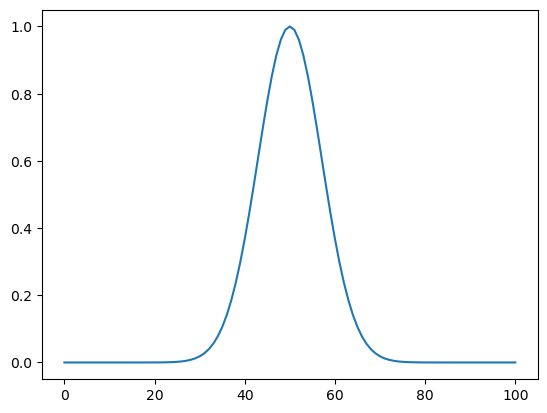

In [6]:
plt.plot(probability_map[50])

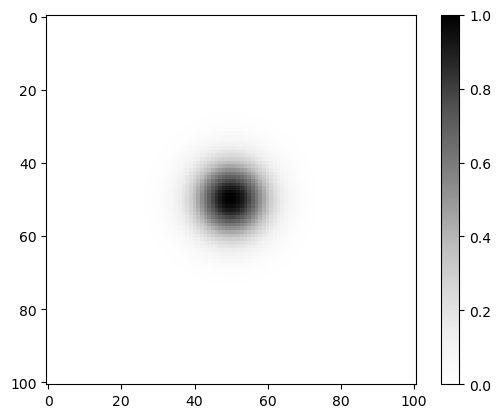

In [7]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

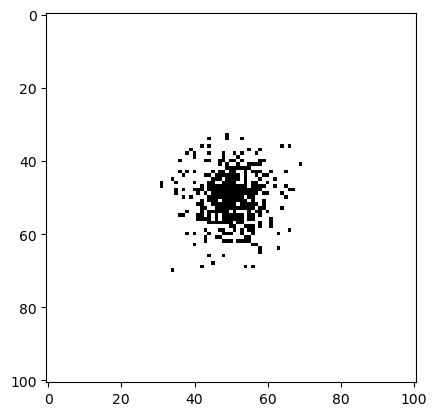

In [8]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cells

In [9]:
def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_radius: int = -1
                       ) -> np.ndarray:
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        if ax_overflow > 0:
            sizes[:int(np.floor(ax_overflow/2))] += 1
            sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

    grid_cells = np.full(space_shape, -1)
    for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # Grid to cell mapping
        grid_cells[*slices] = i

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    if source_radius >= 0:
        # Indices are at source
        at_source = np.sum(((space_shape / 2).astype(int) - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
        grid_cells[*spacial_indices_array[at_source].T] = -1

    return grid_cells

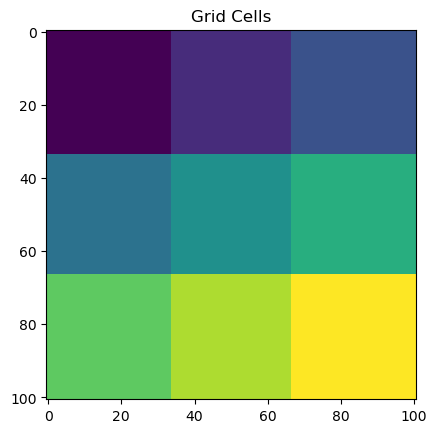

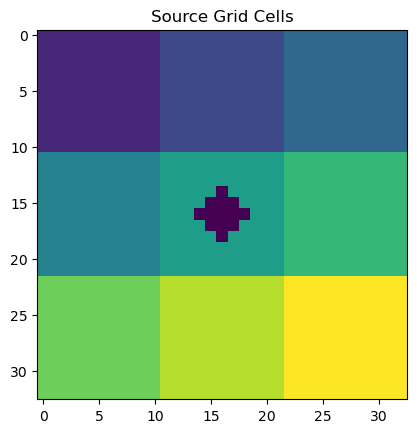

In [10]:
# grid_cells = build_grid_mapping(source_position=np.array([20,20]))
# grid_cells = build_grid_mapping(cells=np.array([5,5]))
# grid_cells = build_grid_mapping(source_cell_resolution=np.array([5,5]))
# grid_cells = build_grid_mapping()
grid_cells = build_grid_mapping(space_shape=space_shape, cells=cells)
grid_source_cells = build_grid_mapping(space_shape=source_cell_shape, cells=source_cell_resolution, source_radius=source_radius)

# Visualize
plt.imshow(grid_cells)
plt.title('Grid Cells')
plt.show()

plt.imshow(grid_source_cells)
plt.title('Source Grid Cells')
plt.show()

### State labels

In [11]:
# Get the list of all indices
indices_list = list(np.ndindex((*cells, *cells)))

In [12]:
cell_indices = list(np.ndindex((*cells,)))
source_cell_indices = list(np.ndindex((*source_cell_resolution,)))

state_labels = []
for (s_y, s_x) in cell_indices:
    state_labels.append(f's_{s_y}_{s_x}')
state_labels += [f'sr_{source_y}_{source_x}' for (source_y, source_x) in source_cell_indices]
state_labels.append('goal')

# Print the indices list
state_labels[:10]

['s_0_0',
 's_0_1',
 's_0_2',
 's_1_0',
 's_1_1',
 's_1_2',
 's_2_0',
 's_2_1',
 's_2_2',
 'sr_0_0']

### Actions

In [13]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Transition probabilities

In [14]:
source_cell_arr = np.ones(source_cell_shape)
half_source_cell_shape = source_cell_shape // 2

cell_count = np.prod(cells)
source_cell_count = np.prod(source_cell_resolution)

# Cell indices array to facilitate the finding of the neighbouring cell indices
cell_indices_arr = np.array(cell_indices)


# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

# Determining cell sizes
cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    if ax_overflow > 0:
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
    cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T


# Building the amount of point going out to neighbour for the action vector
transition_probabilities = np.zeros((len(state_labels), len(action_labels), len(state_labels)))


for a, action_vect in enumerate(action_set):
    non_zero_action_component = (action_vect != 0)
    unit_action_vect = np.zeros(action_vect.shape)
    unit_action_vect[non_zero_action_component] = action_vect[non_zero_action_component] / np.abs(action_vect[non_zero_action_component])

    # Making an array of points that go to the source grid from its vicinity
    # Used in the computation of the average amount of points going to the source cell from anywhere
    points_reaching_source_cell = np.zeros(source_cell_shape + (2 * np.abs(action_vect)), dtype=int)
    points_reaching_source_cell[*[slice(abs(action_vect_dim), (dim_size - abs(action_vect_dim))) for dim_size, action_vect_dim in zip(points_reaching_source_cell.shape, action_vect)]] = -1
    points_reaching_source_cell[*[slice((abs(action_vect_dim) - action_vect_dim), (dim_size - abs(action_vect_dim) - action_vect_dim)) for dim_size, action_vect_dim in zip(points_reaching_source_cell.shape, action_vect)]] += 1
    points_reaching_source_cell[points_reaching_source_cell < 0] = 0

    # Computing the points landing in the source cell
    landing_points_in_source_cell = points_reaching_source_cell[
        slice(0, -2*action_vect[0]) if action_vect[0] > 0 else slice(-2*action_vect[0], None),
        slice(0, -2*action_vect[1]) if action_vect[1] > 0 else slice(-2*action_vect[1], None)
    ]

    # Apply the points landing in the source cell mask
    masked_grid_source_cells = grid_source_cells[landing_points_in_source_cell.astype(bool)]

    # Count points landing in each source cell and computing the landing probability
    unique_values, counts = np.unique(masked_grid_source_cells, return_counts=True)
    all_counts = np.array([(counts[np.argwhere(unique_values == source_cell_id)[0,0]] if source_cell_id in unique_values else 0) for source_cell_id in (np.arange(source_cell_count).tolist() + [-1])])
    source_cell_landing_probabilities = all_counts / np.sum(all_counts)


    # Making an array of points that leave the source grid
    inverse_action_vect = -action_vect
    points_leaving_source_cell = np.zeros(source_cell_shape + (2 * np.abs(inverse_action_vect)), dtype=int)
    points_leaving_source_cell[*[slice(abs(action_vect_dim), (dim_size - abs(action_vect_dim))) for dim_size, action_vect_dim in zip(points_leaving_source_cell.shape, inverse_action_vect)]] = -1
    points_leaving_source_cell[*[slice((abs(action_vect_dim) - action_vect_dim), (dim_size - abs(action_vect_dim) - action_vect_dim)) for dim_size, action_vect_dim in zip(points_leaving_source_cell.shape, inverse_action_vect)]] += 1
    points_leaving_source_cell[points_leaving_source_cell < 0] = 0

    points_reached_from_source_cell = np.zeros(cell_count)


    # Looping over each cell
    for i, cell in enumerate(cell_indices_arr):
        cell_lower_bounds = lower_bounds[i]
        cell_upper_bounds = upper_bounds[i]

        i_grid_cell = (grid_cells == i).astype(int)
        i_grid_cell_padded = np.pad(i_grid_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

        i_cell_area = np.sum(i_grid_cell)

        # Computing the average amount of overlap for cell
        overlap = convolve2d(i_grid_cell_padded, source_cell_arr, mode='valid')
        assert all(overlap.shape == space_shape)
        average_overlap_cell = np.mean(overlap)


        # Computing the amount of points going out to neighbour cells
        # Vertical component
        vert_cell = cell + np.array([unit_action_vect[0], 0])
        has_vert_cell = non_zero_action_component[0] and all((vert_cell >= 0) & (vert_cell < cells))
        if has_vert_cell:
            points_neighbour_cell = np.zeros(i_grid_cell.shape, dtype=int)
            points_neighbour_cell[
                slice((cell_upper_bounds[0] - action_vect[0]), cell_upper_bounds[0]) if (action_vect[0] >= 0) else slice(cell_lower_bounds[0], (cell_lower_bounds[0] - action_vect[0])),
                slice(cell_lower_bounds[1], (cell_upper_bounds[1] - action_vect[1])) if (action_vect[1] >= 0) else slice((cell_lower_bounds[1] - action_vect[1]), cell_upper_bounds[1])
            ] = 1
            points_neighbour_cell_padded = np.pad(points_neighbour_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

            # Computing the overlap
            overlap = convolve2d(points_neighbour_cell_padded, source_cell_arr, mode='valid')
            assert all(overlap.shape == space_shape)

            # Computing amount of points leaving to neighbour
            vert_cell_index = np.argwhere(np.all(cell_indices_arr == vert_cell, axis=1))[0,0]
            assert vert_cell_index != i
            leaving_to_neighbour_count = (np.sum(points_neighbour_cell_padded) - np.mean(overlap)) # Remove the overlap!

            # Computing probability to move out to neighbour cell
            transition_probabilities[i, a, vert_cell_index] = leaving_to_neighbour_count / (i_cell_area - average_overlap_cell)

        # Horizontal component
        hori_cell = cell + np.array([0, unit_action_vect[1]])
        has_hori_cell = non_zero_action_component[1] and all((hori_cell >= 0) & (hori_cell < cells))
        if has_hori_cell:
            points_neighbour_cell = np.zeros(i_grid_cell.shape, dtype=int)
            points_neighbour_cell[
                slice(cell_lower_bounds[0], (cell_upper_bounds[0] - action_vect[0])) if action_vect[0] >= 0 else slice((cell_lower_bounds[0] - action_vect[0]), cell_upper_bounds[0]),
                slice((cell_upper_bounds[1] - action_vect[1]), cell_upper_bounds[1]) if action_vect[1] >= 0 else slice(cell_lower_bounds[1], (cell_lower_bounds[1] - action_vect[1]))
            ] = 1
            points_neighbour_cell_padded = np.pad(points_neighbour_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

            # Computing the overlap
            overlap = convolve2d(points_neighbour_cell_padded, source_cell_arr, mode='valid')
            assert all(overlap.shape == space_shape)

            # Computing amount of points leaving to neighbour
            hori_cell_index = np.argwhere(np.all(cell_indices_arr == hori_cell, axis=1))[0,0]
            assert hori_cell_index != i
            leaving_to_neighbour_count = (np.sum(points_neighbour_cell_padded) - np.mean(overlap)) # Remove the overlap!

            # Computing probability to move out to neighbour cell
            transition_probabilities[i, a, hori_cell_index] = leaving_to_neighbour_count / (i_cell_area - average_overlap_cell)

        # Diagonal component
        diag_cell = cell + unit_action_vect
        if has_vert_cell and has_hori_cell:
            points_neighbour_cell = np.zeros(i_grid_cell.shape, dtype=int)
            points_neighbour_cell[
                slice((cell_upper_bounds[0] - action_vect[0]), cell_upper_bounds[0]) if action_vect[0] >= 0 else slice(cell_lower_bounds[0], (cell_lower_bounds[0] - action_vect[0])),
                slice((cell_upper_bounds[1] - action_vect[1]), cell_upper_bounds[1]) if action_vect[1] >= 0 else slice(cell_lower_bounds[1], (cell_lower_bounds[1] - action_vect[1]))
            ] = 1
            points_neighbour_cell_padded = np.pad(points_neighbour_cell, pad_width=half_source_cell_shape[:,None].repeat(2,axis=1), mode='constant', constant_values=0)

            # Computing the overlap
            overlap = convolve2d(points_neighbour_cell_padded, source_cell_arr, mode='valid')
            assert all(overlap.shape == space_shape)

            # Computing amount of points leaving to neighbour
            diag_cell_index = np.argwhere(np.all(cell_indices_arr == diag_cell, axis=1))[0,0]
            assert diag_cell_index not in [i, vert_cell_index, hori_cell_index]
            leaving_to_neighbour_count = (np.sum(points_neighbour_cell_padded) - np.mean(overlap)) # Remove the overlap!

            # Computing probability to move out to neighbour cell
            transition_probabilities[i, a, diag_cell_index] = leaving_to_neighbour_count / (i_cell_area - average_overlap_cell)


        # Computing the average amount of points going to the source cells from anywhere
        padded_overlap = convolve2d(i_grid_cell_padded, points_reaching_source_cell, mode='valid')
        overlap = padded_overlap[*[slice(abs(action_vect_dim), (dim_size - abs(action_vect_dim))) for dim_size, action_vect_dim in zip(padded_overlap.shape, action_vect)]]
        average_out_to_source_cell = np.mean(overlap)

        # Computing probability to move out to source cells
        to_source_grid_probability = average_out_to_source_cell / i_cell_area
        transition_probabilities[i, a, cell_count + np.arange(source_cell_count)] = to_source_grid_probability * source_cell_landing_probabilities[:-1]
        transition_probabilities[i, a, -1] = to_source_grid_probability * source_cell_landing_probabilities[-1] # Goal state


        # Computing the average amount of points coming from the source cells from anywhere
        padded_overlap = convolve2d(i_grid_cell_padded, points_leaving_source_cell, mode='valid')
        overlap = padded_overlap[*[slice(abs(action_vect_dim), (dim_size - abs(action_vect_dim))) for dim_size, action_vect_dim in zip(padded_overlap.shape, action_vect)]]
        average_out_from_source_cell = np.mean(overlap)

        # Computing the average amount of points coming from the source cells
        points_reached_from_source_cell[i] = average_out_from_source_cell


    # Computing the transition probabilities to other source cell or out of the source grid
    source_grid_indices = np.array(list(np.ndindex(tuple(source_cell_shape))))
    moved_source_grid_indices = source_grid_indices + action_vect
    valid_moved_indices = np.all((moved_source_grid_indices >= 0) & (moved_source_grid_indices < source_cell_shape), axis=1)

    # Get the cell ids
    start_cell_ids = grid_source_cells[*source_grid_indices.T]
    target_cell_ids = np.full(start_cell_ids.shape, -2)
    target_cell_ids[valid_moved_indices] = grid_source_cells[*moved_source_grid_indices[valid_moved_indices].T]

    # Compute confusion matrix
    conf = confusion_matrix(start_cell_ids, target_cell_ids, labels=([-2, -1] + np.arange(source_cell_count).tolist()), normalize='true')

    # Set the transition probabilities
    transition_probabilities[cell_count:(cell_count + source_cell_count), a, cell_count:(cell_count + source_cell_count)] = conf[2:,2:]


    # To and from goal state
    transition_probabilities[cell_count:(cell_count + source_cell_count), a, -1] = conf[2:,1]
    # transition_probabilities[-1, a, -1] = 1.0
    transition_probabilities[-1, a, :-1] = 1.0 / (len(state_labels) - 1) # Loops back to any other state


    # Computing the transition probabilities from the source grid
    transition_probabilities[cell_count:(cell_count + source_cell_count), a, :cell_count] = (conf[2:,0][:,None] * (points_reached_from_source_cell / np.sum(points_reached_from_source_cell))[None,:])


    # Computing the probabilities to stay in the same cell
    transition_probabilities[np.arange(cell_count), a, np.arange(cell_count)] = 1 - np.sum(transition_probabilities[np.arange(cell_count), a], axis=1)


assert np.all(transition_probabilities >= 0) and np.all(transition_probabilities <= 1.0) and np.all(np.sum(transition_probabilities, axis=2).round(8) == 1.0)

### Observations

In [15]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [16]:
agent_state_labels = state_labels[:cell_count]

agent_state_labels[:5]

['s_0_0', 's_0_1', 's_0_2', 's_1_0', 's_1_1']

In [17]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')

# Adding the agent position to the oservation labels
all_observation_labels = []
for obs in observation_labels:
    for agent_state in agent_state_labels:
        all_observation_labels.append(f'{agent_state}-{obs}')

observation_labels = all_observation_labels

# Add goal
observation_labels.append('goal')

### Observation Probabilities

In [18]:
# Splitting the center cell grid into subcells
sub_cell_size_standard = (source_cell_shape / source_cell_resolution).astype(int)
sub_cell_size_overflow = (source_cell_shape % source_cell_resolution).astype(int)

sub_cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(source_cell_resolution, sub_cell_size_standard, sub_cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    if ax_overflow > 0:
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
    sub_cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
sub_cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in sub_cell_sizes]

sub_cell_lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in sub_cell_edges], indexing='ij')]).T
sub_cell_upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in sub_cell_edges], indexing='ij')]).T

# Finding the center cell and its lower bound
lower_bound_center_source_cell = space_center - (source_cell_shape / 2).astype(int)

sub_grid_cell_probabilities = np.full(source_cell_resolution, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(source_cell_resolution))), sub_cell_lower_bounds, sub_cell_upper_bounds):
    lower_b += lower_bound_center_source_cell
    upper_b += lower_bound_center_source_cell
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    sub_grid_cell_probabilities[*cell] = np.average(probability_map[*slices].astype(float))

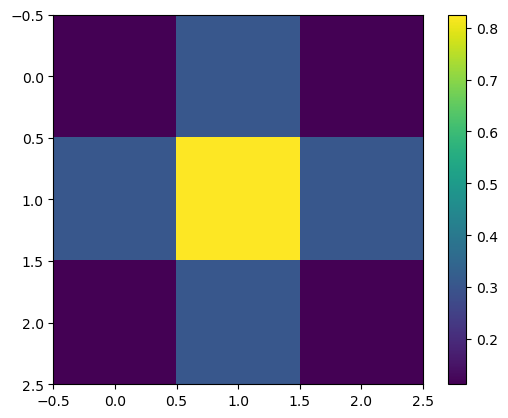

In [19]:
plt.imshow(sub_grid_cell_probabilities)
plt.colorbar()

In [22]:
# Generating an empty observation matrix
observations = np.zeros((len(state_labels), len(action_set), len(observation_labels)))

# Set chance to observe something out of the subgrid
small_non_zero_obs_chance = 0.0
observations[np.arange(cell_count), :, (np.arange(cell_count) + cell_count)] = small_non_zero_obs_chance # Prob to observe something
observations[np.arange(cell_count), :, np.arange(cell_count)] = 1 - small_non_zero_obs_chance # Prob to observe nothing

# Set probabilities for the subgrid
source_cell_indices_arr = np.array(source_cell_indices)
sub_cell_cues = sub_grid_cell_probabilities[*source_cell_indices_arr.T]
observations[np.arange(source_cell_count) + cell_count, :, cell_count:cell_count*2] = (sub_cell_cues[:,None,None] / cell_count) # Prob to observe something
observations[np.arange(source_cell_count) + cell_count, :, :cell_count] = ((1 - sub_cell_cues[:,None,None]) / cell_count) # Prob to observe nothing

# Goal observations
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

assert np.all(observations.sum(axis=-1).round(8) == 1.0)

### Model

In [23]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [len(state_labels)-1], # The very last state is the goal state
    seed=12131415
)

## Training Agent

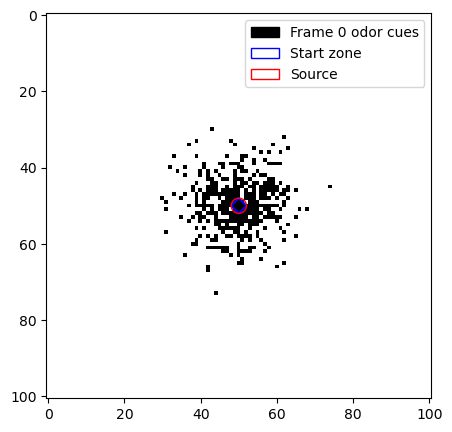

In [24]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              boundary_condition='stop',
                              start_zone='data_zone',
                              odor_present_threshold=3e-1)

artificial_env.plot()

## FSVI agent

In [25]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [26]:
_ = ag.train(expansions=300, use_gpu=True, gamma=0.999)

[01/16/2025, 17:33:04] MDP_policy, not provided. Solving MDP with Value Iteration...
[01/16/2025, 17:33:04] Sending Model to GPU...
[01/16/2025, 17:33:04]     > Done in 0.194s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 19-state, 4-action
  - Converged in 1000 iterations and 1.3594 seconds
  - Took on average 0.0014s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Converged!
Summary of Point Based Value Iteration run
  - Model: 19 state, 4 action, 19 observations
  - Converged or stopped after 144 expansion steps and 144 backup steps.
  - Resulting value function has 789 alpha vectors.
  - Converged in 2.1603s

  - Expand function took on average 0.0115s and yielded on average 361.60 beliefs per iteration. (0.0002s/it/belief)
  - Backup function took on average 0.0035s and yielded on average 5.47 alpha vectors per iteration. (0.0000s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


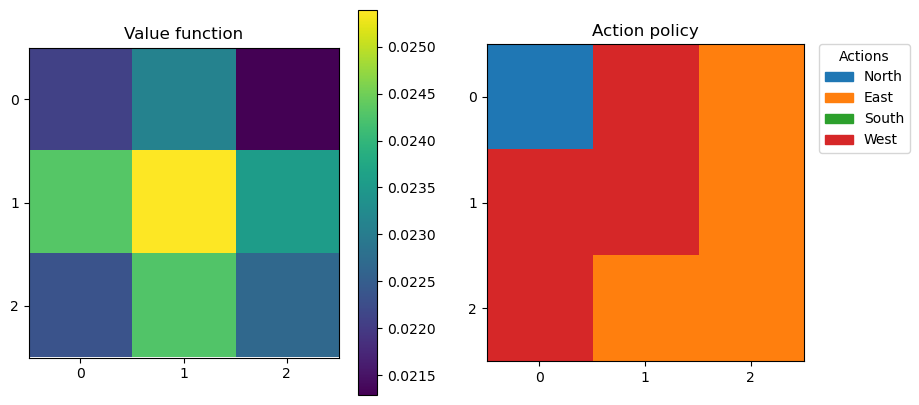

In [27]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [0,0]
source_policy_id = np.arange(np.prod(cells)).reshape(cells)[*source_policy]
# source_state_start = source_policy_id * np.prod(cells)
source_state_start = 0

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

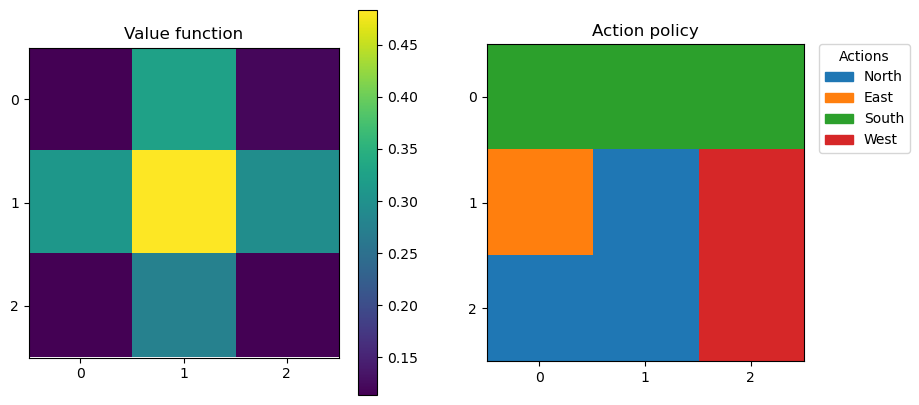

In [29]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = source_cell_resolution

# ! Select here which source to plot
source_policy = [0,0]
source_policy_id = np.arange(np.prod(cells)).reshape(cells)[*source_policy]
# source_state_start = source_policy_id * np.prod(cells)
source_state_start = np.prod(cells)

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+source_cell_count]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+source_cell_count]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

## Testing agent

In [30]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [31]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

### Running test

In [32]:
hist = run_test(ag,
                n=n,
                horizon=1000,
                start_points=start_points,
                environment=env,
                use_gpu=True)

Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 4.856s:
Simulations reached goal: 126/10188 (10062 failures (reached horizon: 10062)) (1.24% success)
 - Average step count:                 988.217 +- 105.58 (Successful only: 47.246 +- 69.29)
 - Extra steps:                        939.659 +- 103.27 (Successful only: 37.063 +- 69.53)
 - Average discounted rewards (ADR):   0.009 +- 0.09 (Successful only: 0.729 +- 0.28)
 - Tmin/T:                             0.056 +- 0.08 (Successful only: 0.620 +- 0.35)


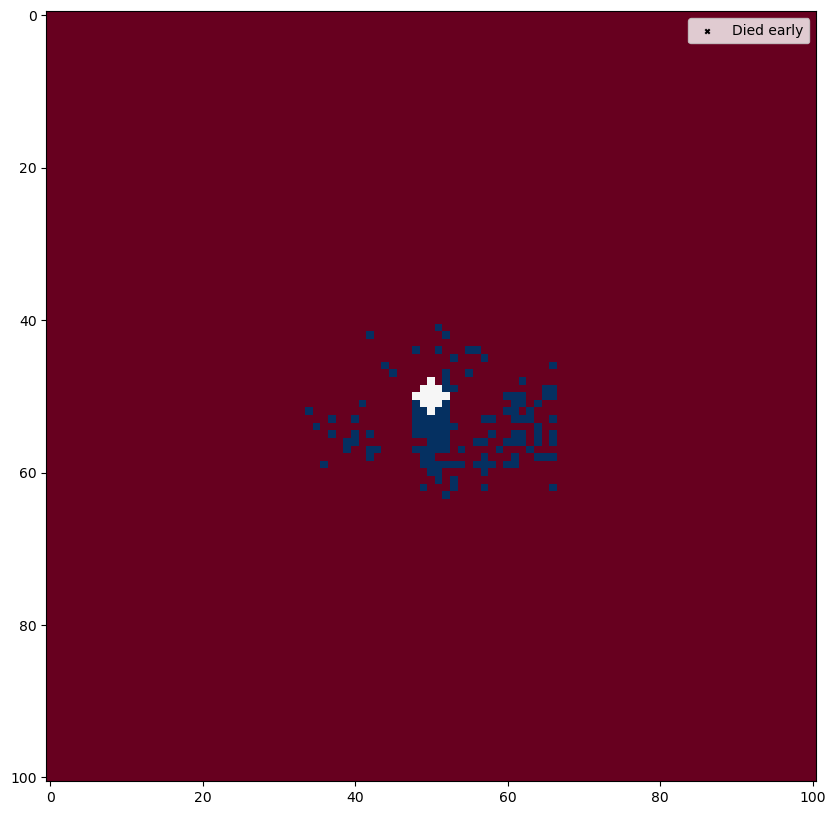

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

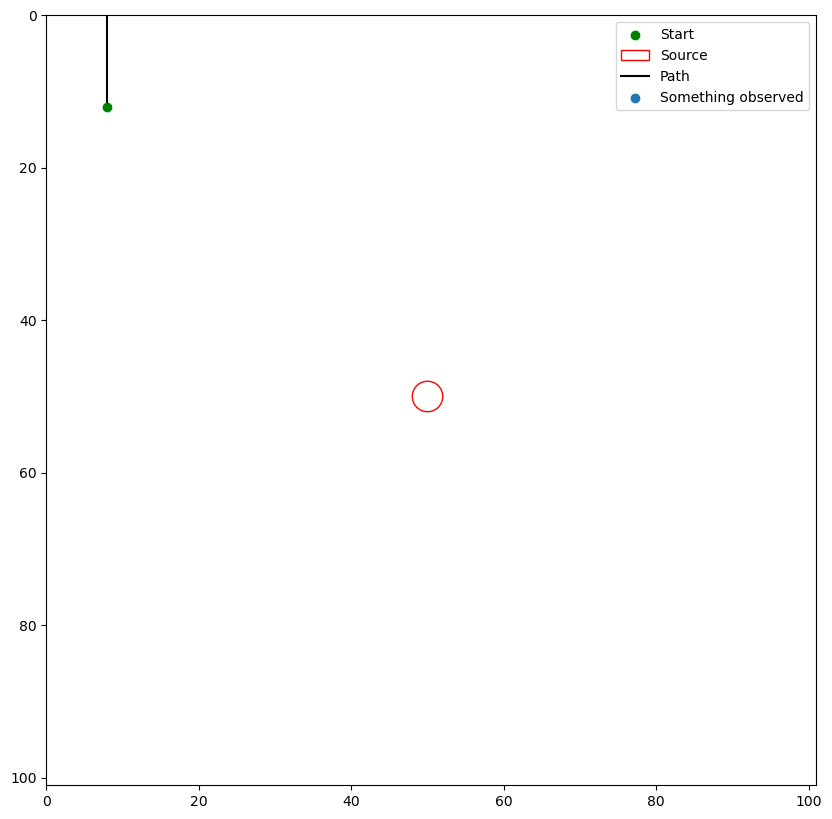

In [34]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(1220, ax= ax)

In [37]:
hist.simulation_dfs[1220]

,time,y,x,dy,dx,o,reached_source
0,0,12,8,None,None,None,None
1,1,13,8,1,0,0.0,0
2,2,14,8,1,0,0.0,0
3,3,15,8,1,0,0.0,0
4,4,16,8,1,0,0.0,0
...,...,...,...,...,...,...,...
996,996,100,34,1,0,0.0,0
997,997,100,33,0,-1,0.0,0
998,998,100,34,0,1,0.0,0
999,999,100,34,1,0,0.0,0
